GAM is very good choice when we want get some strong and interpretable solution.
It catches and shows carefully nonlinearity between dependent variable( in our case it is binary target ) and predictors.
For binary case logit function uses as a link function to predictors.

Here is a good link to read more carefully about this approach:
https://multithreaded.stitchfix.com/blog/2015/07/30/gam/

In the below cells I will briefly show simple solution based on python library PyGam. 

p.s. Internet has to be turned on for installing Pygam package.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
import random
import os
print(os.listdir("../input"))
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
!pip install pygam

In [3]:
from pygam import LogisticGAM,ExpectileGAM, s, f , te, l,terms

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

#### Folds

In [5]:
skf = StratifiedKFold(n_splits = 4,random_state=0)

ID = train['ID_code'].values
y = train['target'].values
d_train = {}
d_val = {}
i = 0 
for train_index, val_index in skf.split(ID,y):
    d_train = {**d_train, **{i : list(train.loc[train_index,'ID_code'].values) } }
    d_val = {**d_val, **{i : list(train.loc[val_index,'ID_code'].values) } }
    i = i + 1 
    
index = {
    'train' : d_train, 
  'val' : d_val
}

In [6]:
data = pd.read_csv('../input/train.csv')

In [7]:
train = pd.merge(data, pd.DataFrame(data = {'ID_code' : index['train'][0] } ) , how = 'inner', on = 'ID_code')

x_train = train.drop(columns = ['ID_code','target']).values
y_train = train['target'].values

s(0) defines splines for variable 0, lam describes penalization for each var. It is possible to look for best lam using gridsearch.

In [8]:
#For first 6 variables here
lambda_ = np.concatenate( [np.array(np.logspace(3,3,10),ndmin =2 ).T for i in range(6)] ,axis = 1 )
gam = LogisticGAM(s(0) +s(1)+s(2)+ s(3)+s(4)+s(5)).gridsearch(
      x_train, 
    y_train, lam = lambda_)

100% (10 of 10) |########################| Elapsed Time: 0:01:18 Time:  0:01:18


Using plot from partial dependence it is clear to see real "correlation" between variable and target.. Mostly, it is not linear. One can also uses this plots to make variable transformation, so new transformed variable will have more linear connection with target

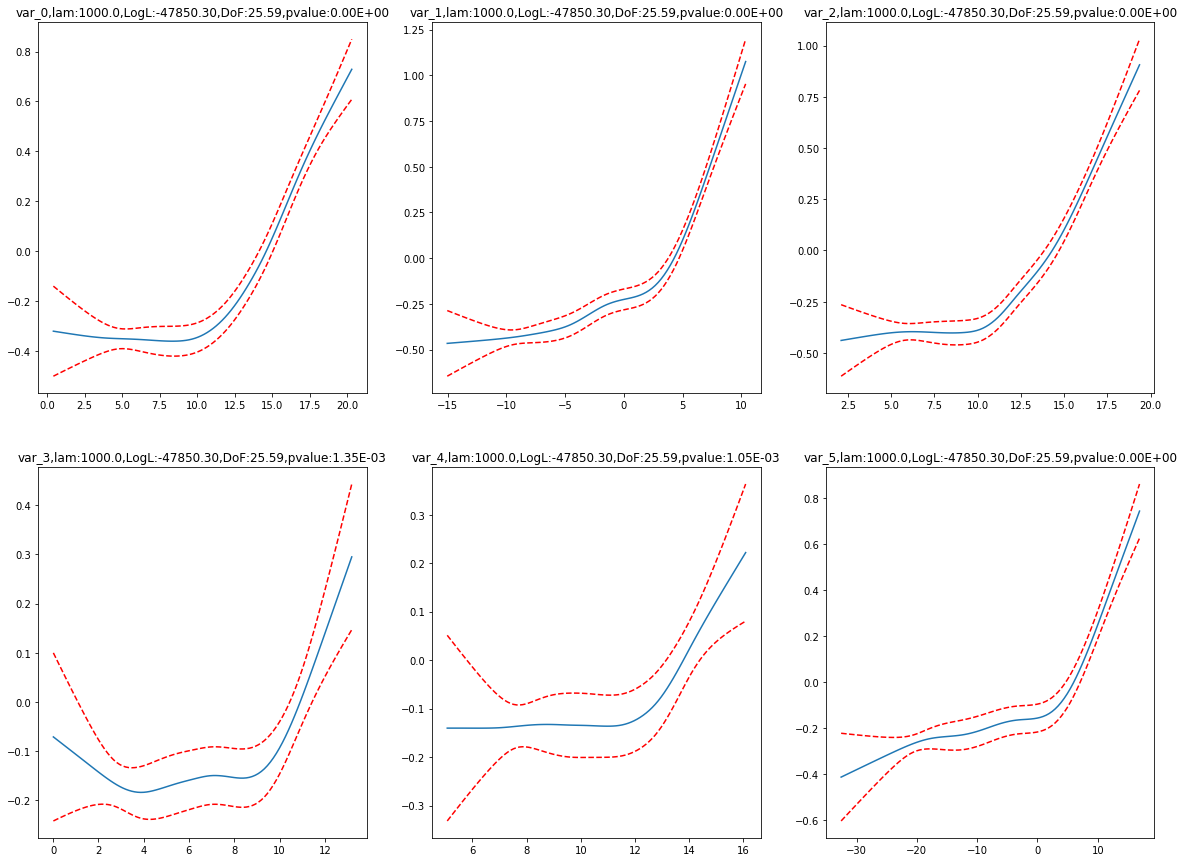

In [9]:
#Now Plot partial dependence the Logit Function Vs Variable
k = 0
fig, ax = plt.subplots(2, 3, figsize = (20,15))
axi = ax.flatten()
for k in range(6):
    titles = ['var_'+str(k) + ',lam:' + '%.1f' %gam.lam[k][0] + 
              ',LogL:' + '%.2f' %gam.statistics_['loglikelihood'] + 
              ',DoF:' + '%.2f' %gam.statistics_['edof'] + ',pvalue:' 
              + '%.2E' %gam.statistics_['p_values'][k] ]

    XX = gam.generate_X_grid(term = k)
    pdep, confi = gam.partial_dependence(term=k, width=.95)
    axi[k].plot(XX[:, k], pdep)
    axi[k].plot(XX[:, k], confi, c='r', ls='--')
    axi[k].set_title(titles[0])

Simple "toy" Model ~ 20 minutes ( 4 folds from the beginning( to calc cross_val ROC), 2 bags in each fold + 1 random set of 50 variables( 8 models )). number of splines and lam are default ) It is possible to play with these parameters like we do it in different "trees" examples.. Sometimes you need make your train sample a bit little to fit it in yout RAM memory.

In [24]:
roc_sc = []
test_pred = []

test = pd.read_csv('../input/test.csv')
x_test = test.drop(columns = ['ID_code']).values

state_ = 125
skf = StratifiedKFold(n_splits = 2,random_state = state_)

## 3 bags for each fold
# pb_metafeature = pd.DataFrame( columns = ['ID_code', 'pb_gam' ] ) 
for i in range(4):
    
    train = pd.merge(data, pd.DataFrame(data = {'ID_code' : index['train'][i] } ) , how = 'inner', on = 'ID_code')
    val = pd.merge(data, pd.DataFrame(data = {'ID_code' : index['val'][i] } ) , how = 'inner', on = 'ID_code')
    x_train = train.drop(columns = ['ID_code','target']).values
    x_val = val.drop(columns = ['ID_code','target']).values
    y_train = train['target'].values
    y_val = val['target'].values
    
    y_pred = 0
    y_test = 0  
    st = time.time()
    bag_iter = 0 
    
    for _, bag_index  in skf.split(x_train,y_train):
        y_pred_bag = 0
        y_test_bag = 0 
        r = 0 #for models number
        ##variables cycle
        for seed_ in [10]:
            random.seed(int(i+bag_iter+seed_))
            var_ind = random.sample(range(200),50)
#             print(var_ind)
            gam = LogisticGAM(
                    s(0,n_splines=20, lam=.6 )+s(1,n_splines = 20, lam = .6)+s(2,n_splines=20, lam=.6)+s(3,n_splines = 20, lam=.6)+
                    s(4,n_splines = 20, lam=.6) +s(5,n_splines = 20, lam=.6) +s(6,n_splines = 20, lam=.6) +s(7,n_splines = 20, lam=.6) +
                    s(8,n_splines = 20, lam=.6) +s(9,n_splines = 20, lam=.6) +s(10,n_splines = 20, lam=.6) +s(11,n_splines = 20, lam=.6) +
                    s(12,n_splines = 20, lam=.6) +s(13,n_splines = 20, lam=.6) +s(14,n_splines = 20, lam=.6) +s(15,n_splines = 20, lam=.6) +
                    s(16,n_splines = 20, lam=.6) +s(17,n_splines = 20, lam=.6) +s(18,n_splines = 20, lam=.6) +s(19,n_splines = 20, lam=.6) +
                    s(20,n_splines = 20, lam=.6) +s(21,n_splines = 20, lam=.6) +s(22,n_splines = 20, lam=.6) +s(23,n_splines = 20, lam=.6) +
                    s(24,n_splines = 20, lam=.6) +s(25,n_splines = 20, lam=.6) +s(26,n_splines = 20, lam=.6) +s(27,n_splines = 20, lam=.6) +
                    s(28,n_splines = 20, lam=.6) +s(29,n_splines = 20, lam=.6) +s(30,n_splines = 20, lam=.6) +s(31,n_splines = 20, lam=.6) +
                    s(32,n_splines = 20, lam=.6) +s(33,n_splines = 20, lam=.6) +s(34,n_splines = 20, lam=.6) +s(35,n_splines = 20, lam=.6) +
                    s(36,n_splines = 20, lam=.6) +s(37,n_splines = 20, lam=.6) +s(38,n_splines = 20, lam=.6) +s(39,n_splines = 20, lam=.6) +
                    s(40,n_splines = 20, lam=.6) +s(41,n_splines = 20, lam=.6) +s(42,n_splines = 20, lam=.6) +s(43,n_splines = 20, lam=.6) +
                    s(44,n_splines = 20, lam=.6) +s(45,n_splines = 20, lam=.6) +s(46,n_splines = 20, lam=.6) +s(47,n_splines = 20, lam=.6) +
                    s(48,n_splines = 20, lam=.6) +s(49,n_splines = 20, lam=.6) 
#                     s(50,n_splines=20, lam=.6 )+s(51,n_splines = 20, lam = .6)+s(52,n_splines=20, lam=.6)+s(53,n_splines = 20, lam=.6)+
#                     s(54,n_splines = 20, lam=.6) +s(55,n_splines = 20, lam=.6) +s(56,n_splines = 20, lam=.6) +s(57,n_splines = 20, lam=.6) +
#                     s(58,n_splines = 20, lam=.6) +s(59,n_splines = 20, lam=.6) +s(60,n_splines = 20, lam=.6) +s(61,n_splines = 20, lam=.6) +
#                     s(62,n_splines = 20, lam=.6) +s(63,n_splines = 20, lam=.6) +s(64,n_splines = 20, lam=.6) +s(65,n_splines = 20, lam=.6) +
#                     s(66,n_splines = 20, lam=.6) +s(67,n_splines = 20, lam=.6) +s(68,n_splines = 20, lam=.6) +s(69,n_splines = 20, lam=.6) +
#                     s(70,n_splines = 20, lam=.6) +s(71,n_splines = 20, lam=.6) +s(72,n_splines = 20, lam=.6) +s(73,n_splines = 20, lam=.6) +
#                     s(74,n_splines = 20, lam=.6) +s(75,n_splines = 20, lam=.6) +s(76,n_splines = 20, lam=.6) +s(77,n_splines = 20, lam=.6) +
#                     s(78,n_splines = 20, lam=.6) +s(79,n_splines = 20, lam=.6) +s(80,n_splines = 20, lam=.6) +s(81,n_splines = 20, lam=.6) +
#                     s(82,n_splines = 20, lam=.6) +s(83,n_splines = 20, lam=.6) +s(84,n_splines = 20, lam=.6) +s(85,n_splines = 20, lam=.6) +
#                     s(86,n_splines = 20, lam=.6) +s(87,n_splines = 20, lam=.6) +s(88,n_splines = 20, lam=.6) +s(89,n_splines = 20, lam=.6) +
#                     s(90,n_splines = 20, lam=.6) +s(91,n_splines = 20, lam=.6) +s(92,n_splines = 20, lam=.6) +s(93,n_splines = 20, lam=.6) +
#                     s(94,n_splines = 20, lam=.6) +s(95,n_splines = 20, lam=.6) +s(96,n_splines = 20, lam=.6) +s(97,n_splines = 20, lam=.6) +
#                     s(98,n_splines = 20, lam=.6) +s(99,n_splines = 20, lam=.6) +
#                     s(100,n_splines=20, lam=.6 )+s(101,n_splines = 20, lam = .6)+s(102,n_splines=20, lam=.6)+s(103,n_splines = 20, lam=.6)+
#                     s(104,n_splines = 20, lam=.6) +s(105,n_splines = 20, lam=.6) +s(106,n_splines = 20, lam=.6) +s(107,n_splines = 20, lam=.6) +
#                     s(108,n_splines = 20, lam=.6) +s(109,n_splines = 20, lam=.6) +s(110,n_splines = 20, lam=.6) +s(111,n_splines = 20, lam=.6) +
#                     s(112,n_splines = 20, lam=.6) +s(113,n_splines = 20, lam=.6) +s(114,n_splines = 20, lam=.6) +s(115,n_splines = 20, lam=.6) +
#                     s(116,n_splines = 20, lam=.6) +s(117,n_splines = 20, lam=.6) +s(118,n_splines = 20, lam=.6) +s(119,n_splines = 20, lam=.6) +
#                     s(120,n_splines = 20, lam=.6) +s(121,n_splines = 20, lam=.6) +s(122,n_splines = 20, lam=.6) +s(123,n_splines = 20, lam=.6) +
#                     s(124,n_splines = 20, lam=.6) +s(125,n_splines = 20, lam=.6) +s(126,n_splines = 20, lam=.6) +s(127,n_splines = 20, lam=.6) +
#                     s(128,n_splines = 20, lam=.6) +s(129,n_splines = 20, lam=.6) +s(130,n_splines = 20, lam=.6) +s(131,n_splines = 20, lam=.6) +
#                     s(132,n_splines = 20, lam=.6) +s(133,n_splines = 20, lam=.6) +s(134,n_splines = 20, lam=.6) +s(135,n_splines = 20, lam=.6) +
#                     s(136,n_splines = 20, lam=.6) +s(137,n_splines = 20, lam=.6) +s(138,n_splines = 20, lam=.6) +s(139,n_splines = 20, lam=.6) +
#                     s(140,n_splines = 20, lam=.6) +s(141,n_splines = 20, lam=.6) +s(142,n_splines = 20, lam=.6) +s(143,n_splines = 20, lam=.6) +
#                     s(144,n_splines = 20, lam=.6) +s(145,n_splines = 20, lam=.6) +s(146,n_splines = 20, lam=.6) +s(147,n_splines = 20, lam=.6) +
#                     s(148,n_splines = 20, lam=.6) +s(149,n_splines = 20, lam=.6) +
#                     s(150,n_splines=20, lam=.6 )+s(151,n_splines = 20, lam = .6)+s(152,n_splines=20, lam=.6)+s(153,n_splines = 20, lam=.6)+
#                     s(154,n_splines = 20, lam=.6) +s(155,n_splines = 20, lam=.6) +s(156,n_splines = 20, lam=.6) +s(157,n_splines = 20, lam=.6) +
#                     s(158,n_splines = 20, lam=.6) +s(159,n_splines = 20, lam=.6) +s(160,n_splines = 20, lam=.6) +s(161,n_splines = 20, lam=.6) +
#                     s(162,n_splines = 20, lam=.6) +s(163,n_splines = 20, lam=.6) +s(164,n_splines = 20, lam=.6) +s(165,n_splines = 20, lam=.6) +
#                     s(166,n_splines = 20, lam=.6) +s(167,n_splines = 20, lam=.6) +s(168,n_splines = 20, lam=.6) +s(169,n_splines = 20, lam=.6) +
#                     s(170,n_splines = 20, lam=.6) +s(171,n_splines = 20, lam=.6) +s(172,n_splines = 20, lam=.6) +s(173,n_splines = 20, lam=.6) +
#                     s(174,n_splines = 20, lam=.6) +s(175,n_splines = 20, lam=.6) +s(176,n_splines = 20, lam=.6) +s(177,n_splines = 20, lam=.6) +
#                     s(178,n_splines = 20, lam=.6) +s(179,n_splines = 20, lam=.6) +s(180,n_splines = 20, lam=.6) +s(181,n_splines = 20, lam=.6) +
#                     s(182,n_splines = 20, lam=.6) +s(183,n_splines = 20, lam=.6) +s(184,n_splines = 20, lam=.6) +s(185,n_splines = 20, lam=.6) +
#                     s(186,n_splines = 20, lam=.6) +s(187,n_splines = 20, lam=.6) +s(188,n_splines = 20, lam=.6) +s(189,n_splines = 20, lam=.6) +
#                     s(190,n_splines = 20, lam=.6) +s(191,n_splines = 20, lam=.6) +s(192,n_splines = 20, lam=.6) +s(193,n_splines = 20, lam=.6) +
#                     s(194,n_splines = 20, lam=.6) +s(195,n_splines = 20, lam=.6) +s(196,n_splines = 20, lam=.6) +s(197,n_splines = 20, lam=.6) +
#                     s(198,n_splines = 20, lam=.6) +s(199,n_splines = 20, lam=.6) 
                   )

            gam.fit(x_train[bag_index,:][:,var_ind],y_train[bag_index]) 

            y_pred_bag = y_pred_bag + gam.predict_proba(x_val[:,var_ind])
            y_test_bag = y_test_bag + gam.predict_proba(x_test[:,var_ind])
            print('Random Model {} ROC:'.format(r), round(100*roc_auc_score(y_val,y_pred_bag),4), 
                  'time:', round((time.time()-st)/60,2))
            r = r + 1                    
        y_pred = y_pred + y_pred_bag/r
        y_test = y_test + y_test_bag/r
        print('Bag {} ROC:'.format(bag_iter), round(100*roc_auc_score(y_val,gam.predict_proba(x_val[:,var_ind])),4),'time:', round((time.time()-st)/60,2))
        bag_iter = bag_iter + 1 
    print('Fold {} ROC:'.format(i),round(100*roc_auc_score(y_val,y_pred),4),
          'time:', round((time.time()-st)/60,2))
    print('-----------------------------------------------')
    roc_sc.append(roc_auc_score(y_val,y_pred/2))
    test_pred.append(y_test/2)
print('mean cross val ROC: {}'.format(round(100*np.mean(roc_sc),4))) 



Random Model 0 ROC: 74.7764 time: 2.61
Bag 0 ROC: 74.7764 time: 2.69
Random Model 0 ROC: 71.1474 time: 5.62
Bag 1 ROC: 71.1474 time: 5.69
Fold 0 ROC: 78.5057 time: 5.69
-----------------------------------------------
Random Model 0 ROC: 71.35 time: 2.86
Bag 0 ROC: 71.35 time: 2.94
Random Model 0 ROC: 74.5888 time: 5.5
Bag 1 ROC: 74.5888 time: 5.57
Fold 1 ROC: 78.9439 time: 5.58
-----------------------------------------------
Random Model 0 ROC: 74.665 time: 2.9
Bag 0 ROC: 74.665 time: 2.98
Random Model 0 ROC: 73.0613 time: 5.86
Bag 1 ROC: 73.0613 time: 5.93
Fold 2 ROC: 79.3635 time: 5.93
-----------------------------------------------
Random Model 0 ROC: 72.7232 time: 2.96
Bag 0 ROC: 72.7232 time: 3.04
Random Model 0 ROC: 70.74 time: 5.96
Bag 1 ROC: 70.74 time: 6.03
Fold 3 ROC: 75.3971 time: 6.03
-----------------------------------------------
mean cross val ROC: 78.0525


Playing with number of variables/number of random models/number of bags/number of splines and lam for each variable could lead to more accurate result. I was using 4 bags with 20 variables & 40 random models(default number of splines and lam).
Result was about ~89( time ~ 2hours ).
Test probabilities was highly correlated with output of LGBM, less correlation was with Naive Bayes & NN models. 

In [31]:
submit = pd.DataFrame({'ID_code':test['ID_code'],
                       'target':np.mean(np.stack(test_pred, axis = 1),axis = 1 )})
submit.to_csv('submission.csv',index = False)